In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import resnet as RN
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [29]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

In [11]:
setup = "ce"
#setup = "soft"

In [24]:
model = RN.ResNet18()
if setup == "ce":
    path = './checkpoint/CrossEntropy.bin'
    npy_path = './CE.npy'
    npy_target = './CE_tar.npy'
    title = 'TSNE_CrossEntropy'
    states = torch.load(path)
elif setup == "soft":
    path = './checkpoint/LabelSmoothing.bin'
    npy_path = './LS.npy'
    npy_target = './LS_tar.npy'
    title = 'TSNE_LabelSmoothing'
    states = torch.load(path)


In [13]:
model.load_state_dict(states)
model.linear = nn.Flatten()

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

extract = model
extract.cuda()
extract.eval()

out_target = []
out_output = []

for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.cuda(), targets.cuda()
    outputs = extract(inputs)
    output_np = outputs.data.cpu().numpy()
    target_np = targets.data.cpu().numpy()
    out_output.append(output_np)
    out_target.append(target_np[:,np.newaxis])

output_array = np.concatenate(out_output, axis=0)
target_array = np.concatenate(out_target, axis=0)
np.save(npy_path, output_array, allow_pickle=False)
np.save(npy_target, target_array, allow_pickle=False)

Files already downloaded and verified


In [22]:
len(out_target)

79

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
tsne = TSNE(n_components=2, init='pca', random_state=0)
output_array = tsne.fit_transform(output_array)

Text(0.5, 1.0, 'TSNE_CrossEntropy')

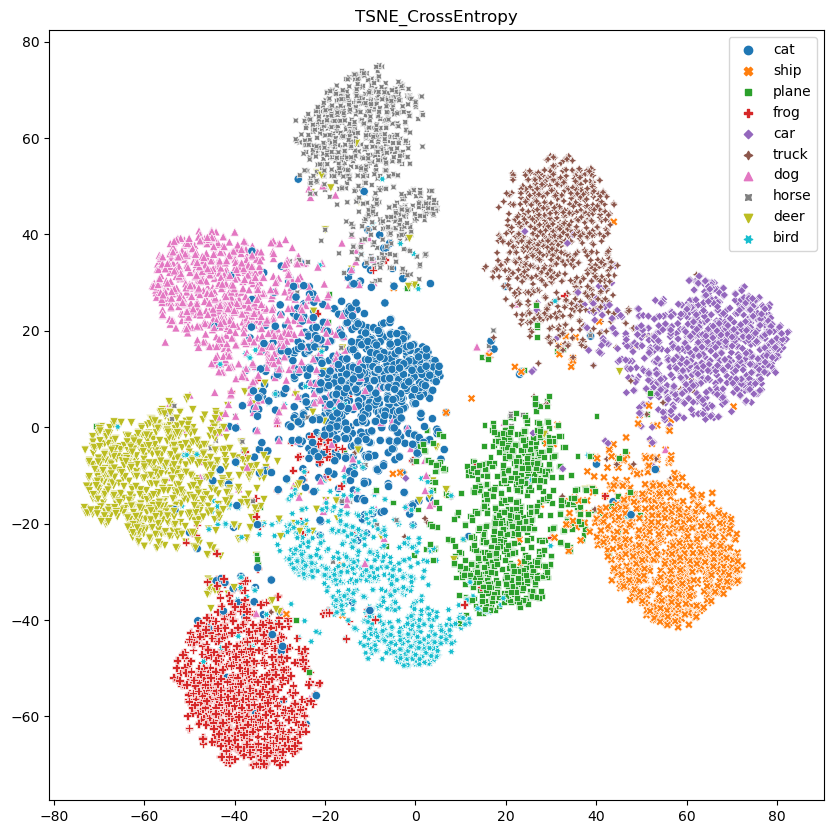

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(x=output_array[:, 0],y=output_array[:, 1],hue=[classes[i] for i in target_array[:,0]],style=[classes[i] for i in target_array[:,0]],ax=ax)
ax.set_title(title)

In [ ]:
fig.savefig('./'+title+'.png', bbox_inches='tight')

In [7]:
CE_test = pd.read_csv('checkpoint_epoch/CrossEntropy_test.csv')
LS_test = pd.read_csv('checkpoint_epoch/LabelSmoothing_test.csv')
SIM_test = pd.read_csv('checkpoint_epoch/SimLabelSmoothing_test.csv')

CE_test['method'] = "CrossEntropy_Loss"
LS_test['method'] = "LabelSmoothing_Avg"
SIM_test['method'] = "LLM_LabelSmoothing"

df = pd.concat([CE_test,LS_test,SIM_test],axis=0,ignore_index=True)

<Axes: xlabel='Epoch', ylabel='Acc'>

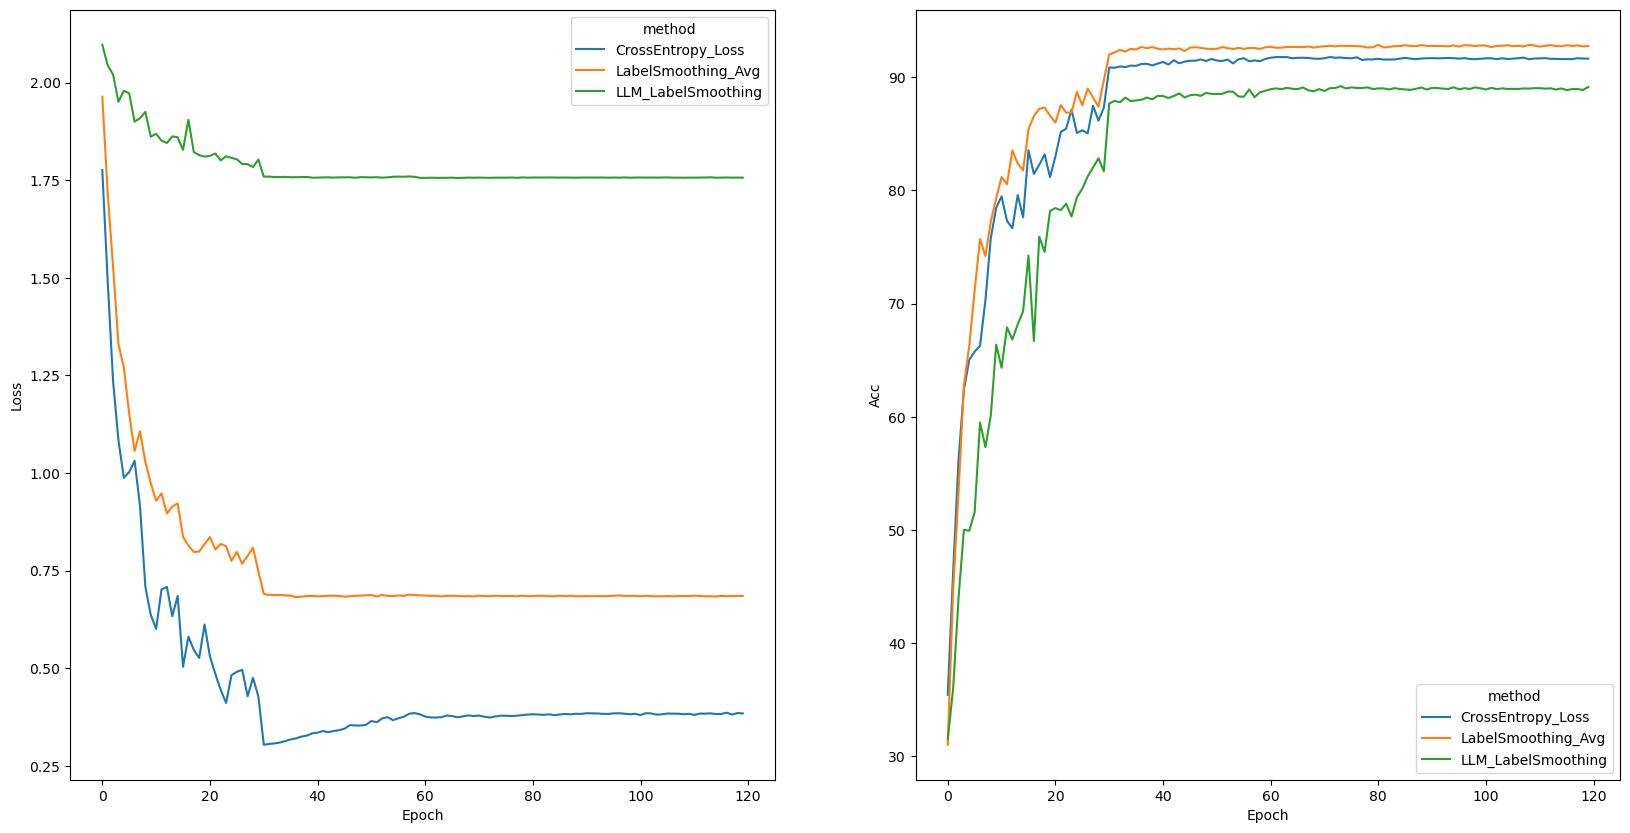

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
sns.lineplot(data=df,x="Epoch",y="Loss",hue="method",ax=ax1)
sns.lineplot(data=df,x="Epoch",y="Acc",hue="method",ax=ax2)

# Plot confusion matrix

In [25]:
model.load_state_dict(states)
# model.linear = nn.Flatten()

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

extract = model
extract.cuda()
extract.eval()

out_target = []
out_output = []

for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.cuda(), targets.cuda()
    outputs = extract(inputs)
    output_np = outputs.data.cpu().numpy()
    target_np = targets.data.cpu().numpy()
    out_output.append(output_np)
    out_target.append(target_np[:,np.newaxis])

output_array = np.concatenate(out_output, axis=0)
target_array = np.concatenate(out_target, axis=0)

Files already downloaded and verified


In [53]:
y_pred = np.argmax(output_array,axis=1)
y_true = np.squeeze(target_array)

In [55]:
cm_data = confusion_matrix(y_true, y_pred)

In [71]:
sim_mat = [
        [1.00, 0.15, 0.25, 0.01, 0.02, 0.03, 0.01, 0.12, 0.29, 0.11],
        [0.15, 1.00, 0.01, 0.10, 0.30, 0.10, 0.10, 0.10, 0.07, 0.90],
        [0.25, 0.01, 1.00, 0.30, 0.45, 0.25, 0.30, 0.18, 0.01, 0.00],
        [0.01, 0.10, 0.30, 1.00, 0.10, 0.80, 0.10, 0.08, 0.00, 0.05],
        [0.02, 0.30, 0.45, 0.10, 1.00, 0.52, 0.05, 0.90, 0.01, 0.15],
        [0.03, 0.10, 0.25, 0.80, 0.52, 1.00, 0.20, 0.36, 0.05, 0.05],
        [0.01, 0.10, 0.30, 0.10, 0.05, 0.20, 1.00, 0.10, 0.10, 0.05],
        [0.12, 0.10, 0.18, 0.08, 0.90, 0.36, 0.10, 1.00, 0.08, 0.25],
        [0.29, 0.07, 0.01, 0.00, 0.01, 0.05, 0.10, 0.08, 1.00, 0.20],
        [0.11, 0.90, 0.00, 0.05, 0.15, 0.05, 0.05, 0.25, 0.20, 1.00]
    ]

In [72]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
df_cm = pd.DataFrame(sim_mat,columns=classes,index=classes)
# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'

[Text(0, 0.5, 'plane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

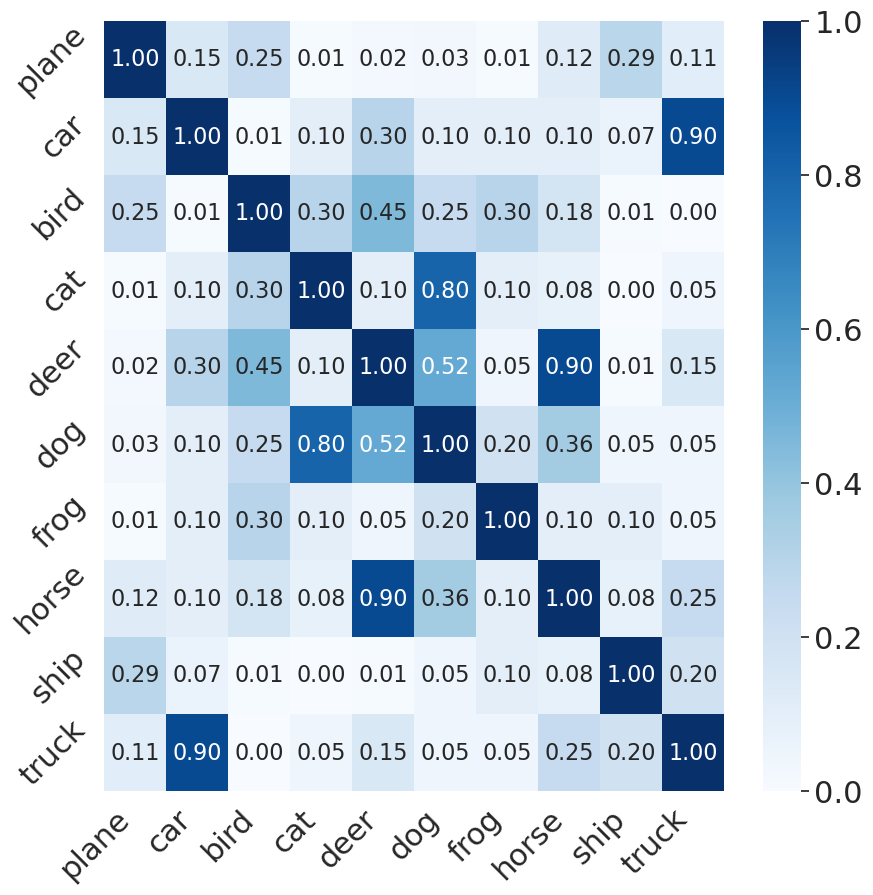

In [75]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(df_cm, cmap="Blues",annot=True,annot_kws={"size": 16},fmt=".2f",ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, ha='right')